In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima, ARIMA
from pmdarima.model_selection import SlidingWindowForecastCV

from eodhd import APIClient
from yahooquery import search

### Installing library

In [ ]:
%pip install eodhd

Note: you may need to restart the kernel to use updated packages.


In [3]:
api = APIClient(api_key='68a888ecbf2185.97717291')

In [4]:
TICKERS = ["AAPL.US", "GOOGL.US", "TSLA.US", "JNJ.US", "JPM.US", "ITX.MC"]

**AAPL.US → Apple Inc.** (tecnología, iPhone, iPad, Mac).

**GOOGL.US → Alphabet Inc. Clase A** (matriz de Google, YouTube, Android).

**TSLA.US → Tesla Inc.** (vehículos eléctricos, baterías, energía).

**JNJ.US → Johnson & Johnson** (farmacéutica y productos de consumo, muy estable).

**JPM.US → JPMorgan Chase & Co.** (banco de inversión y comercial, uno de los más grandes del mundo).

**ITX.MC → Inditex S.A.** (España, grupo textil dueño de Zara, Pull&Bear, Massimo Dutti, etc., cotiza en la Bolsa de Madrid).

##### TICKERS DOWNLOAD

In [ ]:
for i in TICKERS:
    df = pd.DataFrame(api.get_eod_historical_stock_market_data(symbol= i, period='d', from_date='2010-01-01'))
    df.to_csv(f'{i}.csv', index=False)

### Data

In [11]:
df = pd.read_csv('../data/AAPL.US.csv', parse_dates=['date'])    #asegurar que los datos estan en orden
df = df.sort_values('date').reset_index(drop=True)
df

FileNotFoundError: [Errno 2] No such file or directory: '../data/AAPL.US.csv'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3934 entries, 0 to 3933
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            3934 non-null   datetime64[ns]
 1   open            3934 non-null   float64       
 2   high            3934 non-null   float64       
 3   low             3934 non-null   float64       
 4   close           3934 non-null   float64       
 5   adjusted_close  3934 non-null   float64       
 6   volume          3934 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 215.3 KB


In [ ]:
df.describe()

,date,open,high,low,close,adjusted_close,volume
count,3934,3934.00000000,3934.00000000,3934.00000000,3934.00000000,3934.00000000,3934.00000000
mean,2017-10-26 03:59:45.358414080,243.78418597,246.18414865,241.30518088,243.83255048,73.40398716,222902764.33655313
min,2010-01-04 00:00:00,90.00000000,90.70000000,89.47000000,90.28000000,5.76540000,23234700.00000000
25%,2013-11-27 12:00:00,141.62250000,143.18250000,140.23750000,141.80750000,17.98060000,80596025.00000000
50%,2017-10-24 12:00:00,187.73000000,189.28500000,186.09500000,187.93500000,37.18140000,134442000.00000000
75%,2021-09-21 18:00:00,315.29970000,318.23680000,312.15000000,315.29940000,138.53215000,298661300.00000000
max,2025-08-22 00:00:00,702.41080000,705.07080000,699.56880000,702.10000000,258.10380000,1880998000.00000000
std,NaN,145.01751975,146.26738489,143.49089401,144.89900035,70.57924376,216345358.96828377


In [ ]:
df.isnull().value_counts()

date   open   high   low    close  adjusted_close  volume
False  False  False  False  False  False           False     3934
Name: count, dtype: int64

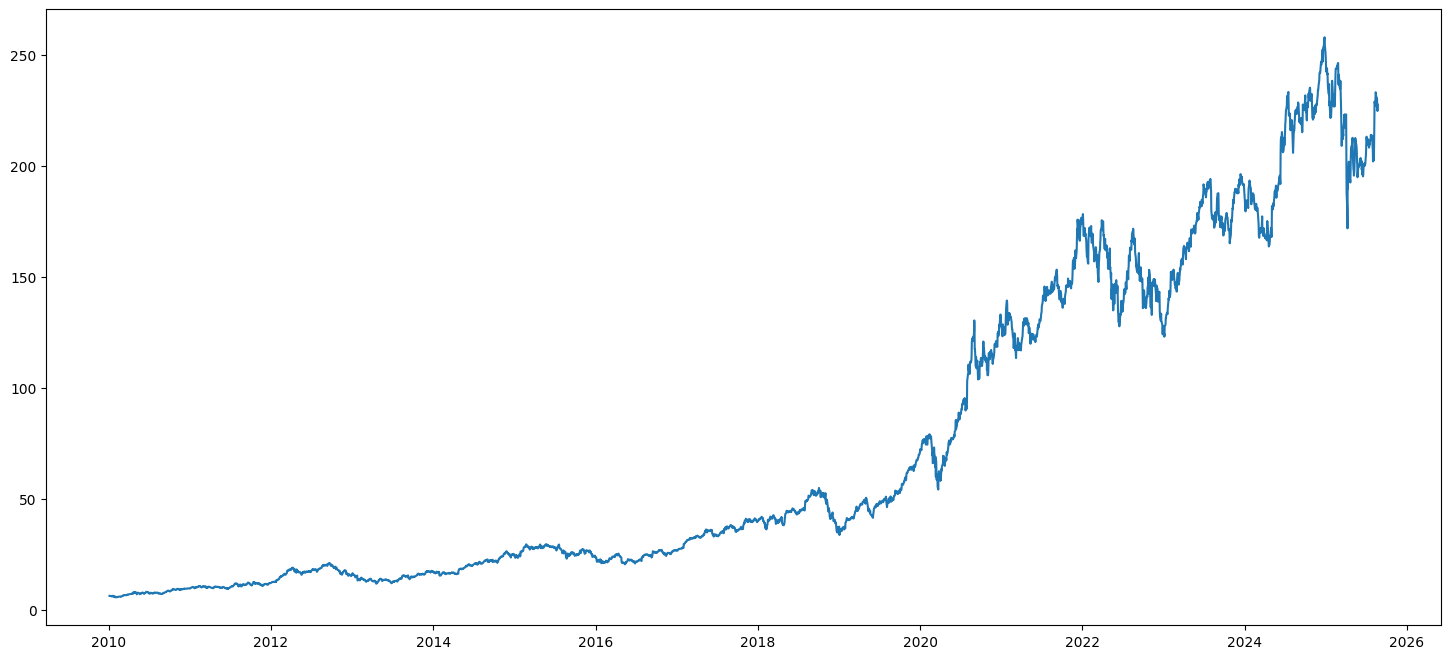

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(df["date"], df["adjusted_close"])